In [1]:
import sqlite3
import pandas as pd

df = pd.read_excel('/content/test.xlsx', sheet_name=1)

conn = sqlite3.connect('mydb.sqlite')
df.to_sql('mytable', conn, if_exists='replace', index=False)


27704

**1.Рассчитать маржу в рублях и % по всей компании в разрезе месяцев**

In [2]:
query = '''

SELECT strftime('%Y-%m', date_create) AS month,
       SUM(price_b2b_gross - cost_price) AS margin_rub_b2b,
       ROUND(AVG((price_b2b_gross - cost_price) / cost_price) * 100, 2) AS margin_pct_b2b,
       SUM(price_b2c_gross - cost_price) AS margin_rub_b2c,
       ROUND(AVG((price_b2c_gross - cost_price) / cost_price) * 100, 2) AS margin_pct_b2c
FROM mytable
WHERE status = 0
GROUP BY MONTH
ORDER BY MONTH

'''

result_df = pd.read_sql_query(query, conn)

In [3]:
result_df

,month,margin_rub_b2b,margin_pct_b2b,margin_rub_b2c,margin_pct_b2c
0,2022-06,9.692180e+05,40.33,1.390342e+06,52.62
1,2022-07,8.522901e+05,35.85,1.233547e+06,47.64
2,2022-08,1.099673e+06,47.26,1.581203e+06,60.90


**2.Выбрать топ 5 самых прибыльных позиций в разрезе каждого РК, за весь период.**

In [4]:
query = '''

SELECT *
FROM
  (SELECT organization_id,
          code,
          SUM((price_b2b_gross - cost_price)*quantity) AS profit,
          DENSE_RANK() OVER(PARTITION BY organization_id
                            ORDER BY SUM((price_b2b_gross - cost_price)*quantity) DESC) AS RNK
   FROM mytable
   WHERE status = 0
   GROUP BY organization_id,
            code
   ORDER BY organization_id,
            profit DESC)
WHERE RNK <= 5

'''
#считаю что все продавалось по price_b2b_gross

result1_df = pd.read_sql_query(query, conn)

In [5]:
result1_df

,organization_id,code,profit,RNK
0,1,62120,46740.075317,1
1,1,64555,38498.030480,2
2,1,40852,29555.685406,3
3,1,46563,21874.755851,4
4,1,57596,20380.309261,5
...,...,...,...,...
65,15,66020,4798.879553,1
66,15,9171,1897.107641,2
67,15,51987,1692.269202,3
68,15,62561,1130.076220,4


**3.В какой день недели клиенты чаще делают покупки. Проанализировать август.**

Вывести: День недели, Среднее количество заказов в этот день

In [6]:
query = '''

WITH TAB1 AS
  (SELECT weekday,
          COUNT(*) AS number
   FROM
     (SELECT DISTINCT strftime('%Y-%m-%d', date_create),
                      strftime('%w', strftime('%Y-%m-%d', date_create)) AS weekday
      FROM mytable
      WHERE strftime('%m', date_create) = '08')
   GROUP BY weekday),

     TAB2 AS
  (SELECT strftime('%w', date_create) AS weekday,
          count(distinct sales_order) AS total
   FROM mytable
   WHERE strftime('%m', date_create) = '08'
   GROUP BY 1
   ORDER BY 1)
SELECT CASE
           WHEN weekday = '0' THEN 'Воскресенье'
           WHEN weekday = '1' THEN 'Понедельник'
           WHEN weekday = '2' THEN 'Вторник'
           WHEN weekday = '3' THEN 'Среда'
           WHEN weekday = '4' THEN 'Четверг'
           WHEN weekday = '5' THEN 'Пятница'
           WHEN weekday = '6' THEN 'Суббота'
       END AS day_of_week,
       avg_number
FROM
  (SELECT TAB1.weekday,
          (total/number) AS avg_number
   FROM TAB1
   JOIN TAB2 ON TAB1.weekday = TAB2.weekday)

'''
# в TAB1 считается сколько раз день недели был в этом месяце
# в TAB2 считается сколько заказов было сделано в день недели за месяц

result2_df = pd.read_sql_query(query, conn)

In [7]:
result2_df

,day_of_week,avg_number
0,Воскресенье,198
1,Понедельник,259
2,Вторник,264
3,Среда,239
4,Четверг,238
5,Пятница,244
6,Суббота,182


**4.Построить динамику доли выкупа заказов по их суммам в разрезе недель за июль.**



In [16]:
query = '''

SELECT week,
       ROUND(SUM(CASE
                     WHEN status=0 THEN total
                     ELSE 0
                 END)/SUM(total), 2) AS fraction
FROM
  (SELECT strftime('%W', date_create) AS week,
          status,
          price_b2b_gross*quantity AS total
   FROM mytable
   WHERE strftime('%m', date_create) = '07')
GROUP BY 1

'''

result3_df = pd.read_sql_query(query, conn)

In [17]:
result3_df

,week,fraction
0,26,0.87
1,27,0.90
2,28,0.85
3,29,0.77
4,30,0.87


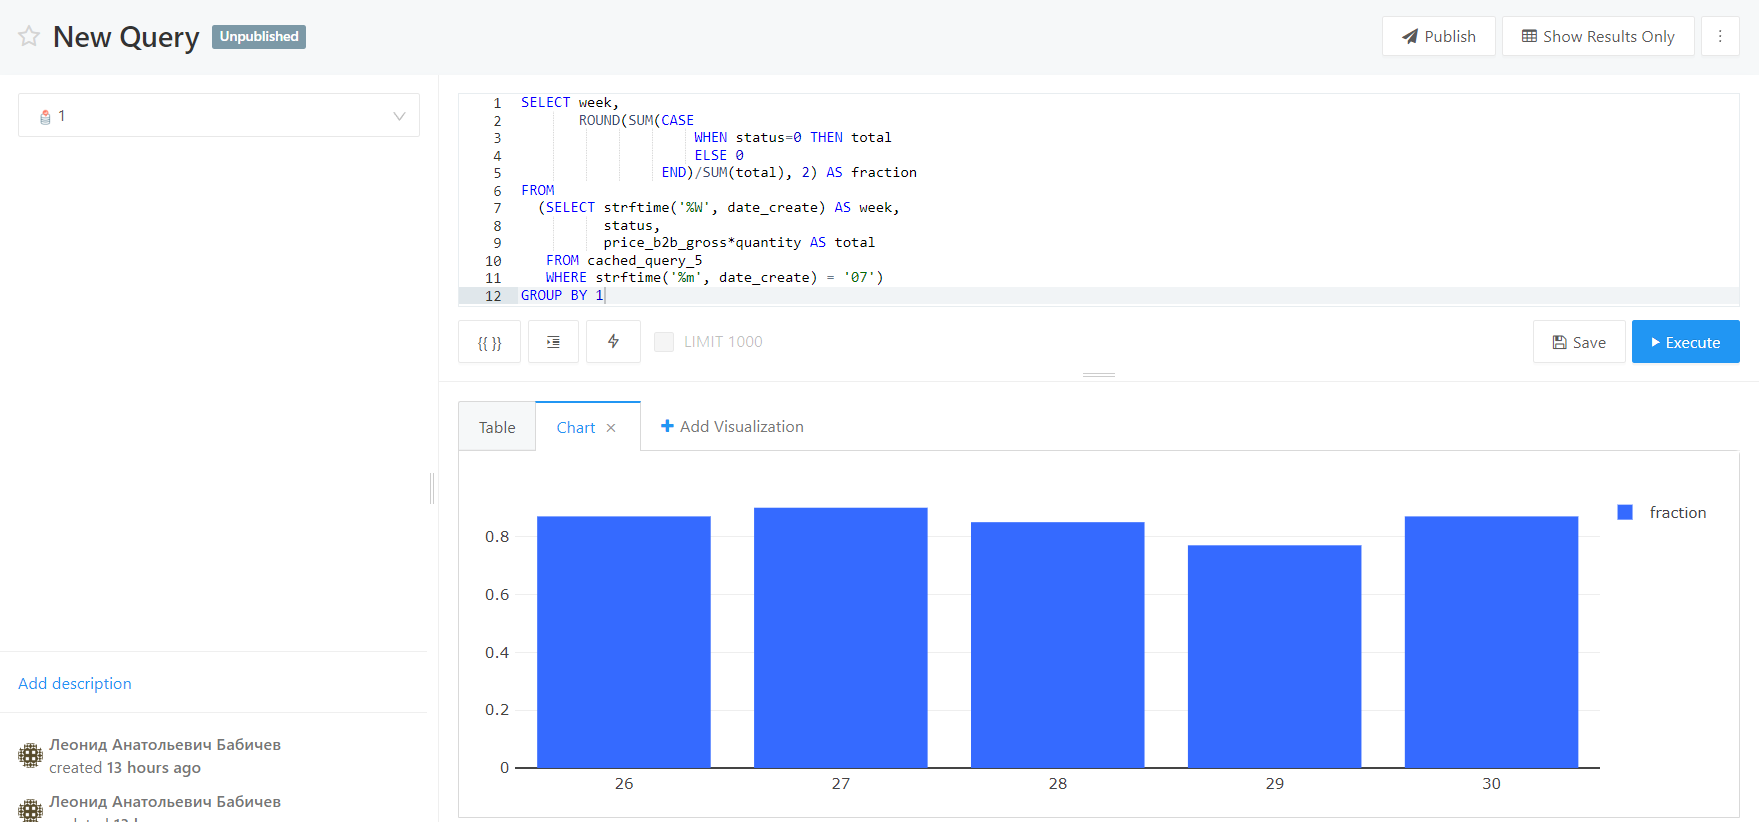

**5.Рассчитать за весь период товары, которые часто продаются друг с другом.**

Вывести: Первый товар, Сопутствующий товар, Количество чеков с данными товарами

In [10]:
query = '''

SELECT *
FROM
  (SELECT p1.code AS product1,
          p2.code AS product2,
          count(*) AS appearances
   FROM mytable p1
   JOIN mytable p2 ON p1.sales_order=p2.sales_order
   AND p1.code < p2.code
   GROUP BY product1,
            product2)
WHERE appearances > 5

'''
#решил что 5 встречаемости достаточно, можно было бы посмотреть процентили и принять решение но на SQLite неудобно

result4_df = pd.read_sql_query(query, conn)

In [11]:
result4_df

,product1,product2,appearances
0,18594,20362,7
1,18594,20365,7
2,18594,20368,7
3,18594,20370,9
4,20362,20363,15
5,20362,20364,10
6,20362,20365,13
7,20362,20368,8
8,20362,20370,12
9,20362,20380,7


**6.Сформировать отчет в редаше с параметрами: Период, Тип отрезка.**

Период - просто выбирает временной период без времени, Тип отрезка - группирует данные по дню, неделе, месяцу, году.

In [12]:
query = '''

SELECT
    CASE
        WHEN '{{type}}' = 'месяц' THEN strftime('%Y-%m', date_create)
        WHEN '{{type}}' = 'неделя' THEN strftime('%Y-%W', date_create)
        WHEN '{{type}}' = 'год' THEN strftime('%Y', date_create)
        WHEN '{{type}}' = 'день' THEN date(date_create)
        ELSE strftime('%Y-%m-%d', date_create)
    END AS Период,
    COUNT(DISTINCT sales_order) AS Количество_заказов
FROM
    cached_query_5
WHERE
    date(date_create) >= date('{{start_period}}')
    AND date(date_create) <= date('{{end_period}}')
GROUP BY
    CASE
        WHEN '{{type}}' = 'месяц' THEN strftime('%Y-%m', date_create)
        WHEN '{{type}}' = 'неделя' THEN strftime('%Y-%W', date_create)
        WHEN '{{type}}' = 'год' THEN strftime('%Y', date_create)
        WHEN '{{type}}' = 'день' THEN date(date_create)
        ELSE strftime('%Y-%m-%d', date_create)
    END

'''

**7.Нужно распарсить и пронумеровать значения  в прямоугольных скобках в текущем порядке.**

Вывести 2 колонки: Порядковый номер, Значение.

Предоставить решение в SQL и решение на Python

решение SQL

In [13]:
query = '''
SELECT
  row_number() OVER() AS id,
  value
FROM
  json_each('[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]')
ORDER BY
  id ASC;
'''

result5_df = pd.read_sql_query(query, conn)

In [14]:
result5_df

,id,value
0,1,174.0
1,2,103.0
2,3,77.0
3,4,42.0
4,5,54.0
5,6,81.0
6,7,140.0
7,8,235.0
8,9,438.0
9,10,557.0


решение python

In [15]:
import json

data_str = '[[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]]'

data = json.loads(data_str)

values = data[0]

for i, value in enumerate(values):
    print(f"{i+1}: {value}")

1: 174.0
2: 103.0
3: 77.0
4: 42.0
5: 54.0
6: 81.0
7: 140.0
8: 235.0
9: 438.0
10: 557.0
11: 688.0
12: 708.0
13: 669.0
14: 612.0
15: 688.0
16: 675.0
17: 933.0
18: 1015.0
19: 998.0
20: 834.0
21: 861.0
22: 658.0
23: 617.0
24: 414.0
